In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

In [2]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '033125'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(cowplot)
library(pheatmap)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_033125.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [3]:
head(full_df)

,HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Value
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2,Volume,TRAP,USEPA,Metal,K,K,34642.92963
2,2,Volume,TRAP,USEPA,Metal,Ca,Ca,512.54300
3,2,Volume,TRAP,USEPA,Metal,Cd,Cd,0.09450
4,2,Volume,TRAP,USEPA,Metal,Fe,Fe,161.62958
5,2,Volume,TRAP,USEPA,Metal,Mn,Mn,2.17625
6,2,Volume,TRAP,USEPA,Metal,Ni,Ni,0.73025


This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [4]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    mutate(HAWC_ID = ifelse(HAWC_ID < 3, Study, HAWC_ID)) %>% 
    group_by(Metric, Class) %>%
    group_split


metal_vol_df = split_df[[1]]
pah_vol_df = split_df[[2]]
voc_vol_df = split_df[[3]]
metal_weight_df = split_df[[4]]
#pah_weight_df = split_df[[5]]

head(metal_vol_df)

HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
USEPA,Volume,TRAP,USEPA,Metal,K,K,34642.92963
USEPA,Volume,TRAP,USEPA,Metal,Ca,Ca,512.54300
USEPA,Volume,TRAP,USEPA,Metal,Cd,Cd,0.09450
USEPA,Volume,TRAP,USEPA,Metal,Fe,Fe,161.62958
USEPA,Volume,TRAP,USEPA,Metal,Mn,Mn,2.17625
USEPA,Volume,TRAP,USEPA,Metal,Ni,Ni,0.73025


In [5]:
# casting wide
wider_metal_vol_df = metal_vol_df %>%
    # creating sample ids
    unite("SampleID", c(colnames(metal_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_pah_vol_df = pah_vol_df %>%
    unite("SampleID", c(colnames(pah_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_voc_vol_df = voc_vol_df %>%
    unite("SampleID", c(colnames(voc_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_metal_weight_df = metal_weight_df %>%
    unite("SampleID", c(colnames(metal_weight_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
# wider_metal_vol_df = volume_df %>%
#     filter(Chemical_Class == 'Metal') %>%
#     # creating sample ids
#     unite("SampleID", c(colnames(volume_df)[c(1,8,6,5)]), remove = FALSE) %>%
#     pivot_wider(names_from = "DTXSID", values_from = "Value") #%>%
#     #column_to_rownames(var = "SampleID")

head(wider_metal_vol_df)

,HAWC_ID,Metric,Data,Study,Class,K,Ca,Cd,Fe,Mn,Ni
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USEPA_TRAP_Metal,USEPA,Volume,TRAP,USEPA,Metal,34642.93,512.543,0.0945,161.6296,2.17625,0.73025
266987_WS_Metal,266987,Volume,WS,Seagrave 2005,Metal,763600.00,49200.000,3500.0000,52600.0000,1800.00000,1538.17875
452289_WS_Metal,452289,Volume,WS,Rabha 2018,Metal,82955.29,28681.554,30.0000,3175.1014,290.00000,170.00000
885041_WS_Metal,885041,Volume,WS,Ihantola et al. 2020,Metal,99550.00,3710.000,152.0000,1088.5000,133.00000,25.75000
993956_WS_Metal,993956,Volume,WS,Ihantola et al. 2022,Metal,60000.00,2800.000,25.0000,1400.0000,280.00000,47.00000
1263480_WS_Metal,1263480,Volume,WS,Burnet et al. 1990,Metal,1593166.67,374250.000,1833.3333,25791.6667,11708.33333,1375.00000


# Principal Component Analysis (PCA)

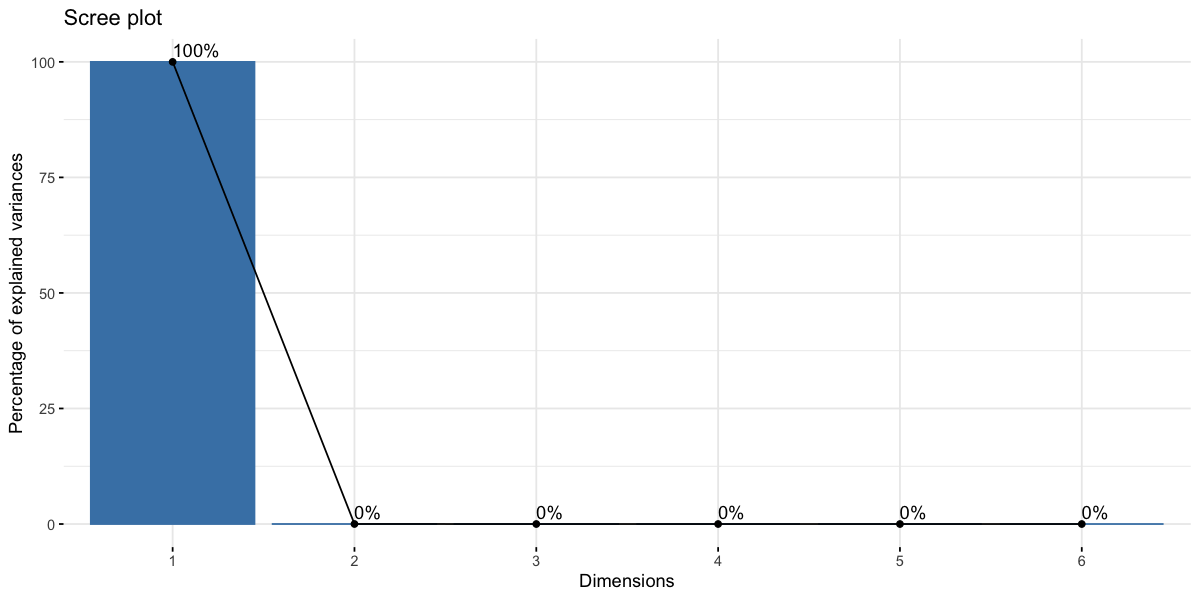

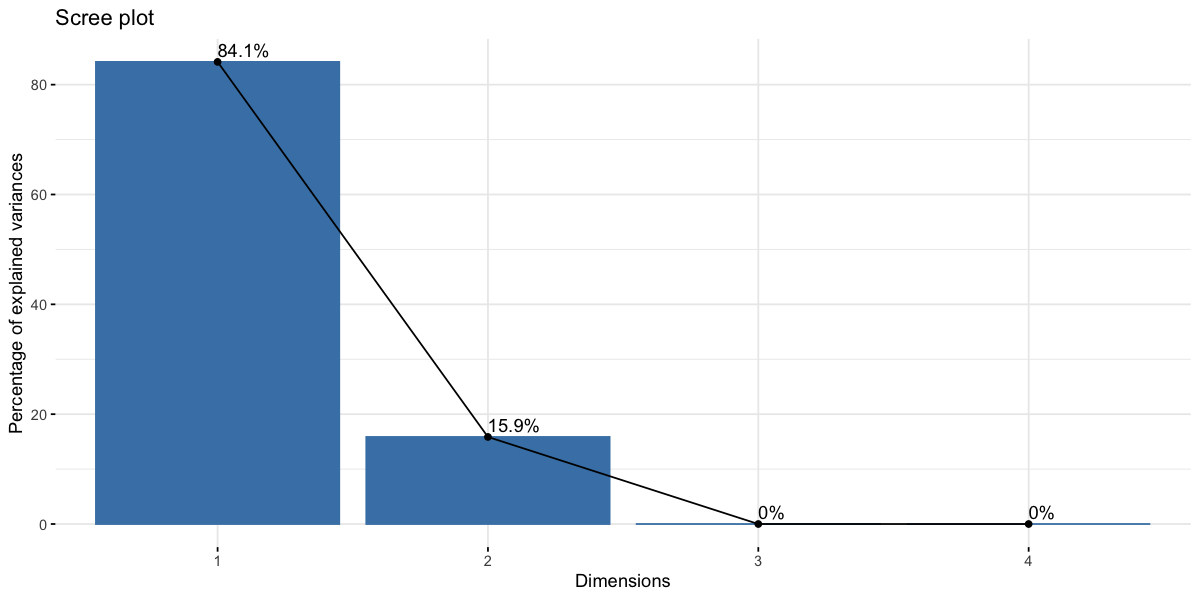

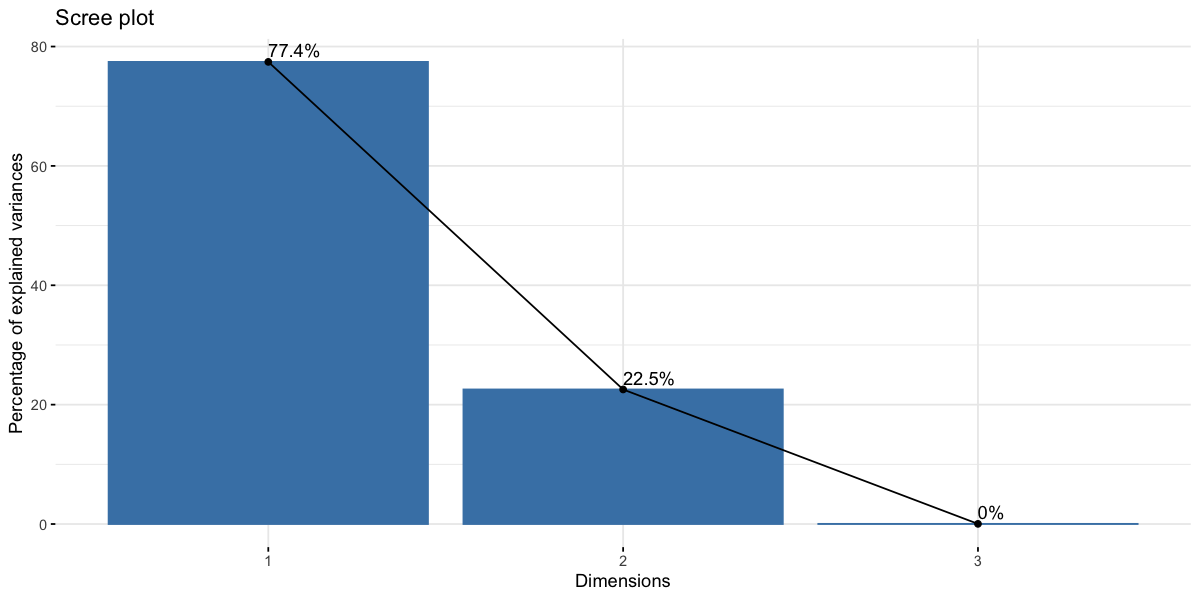

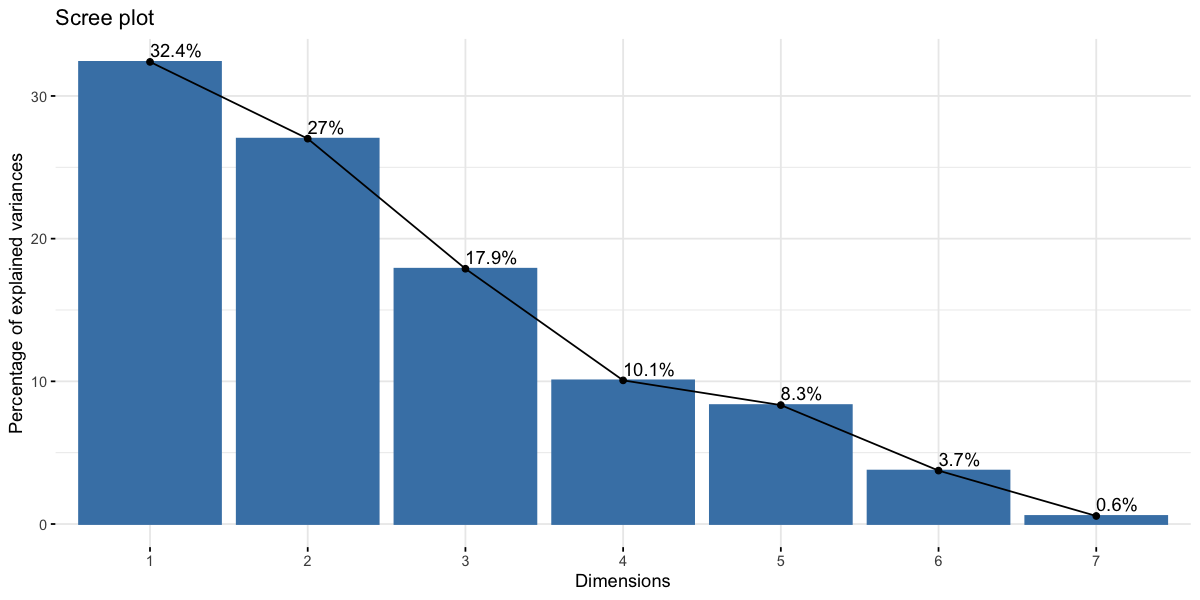

In [6]:
# running pca 
metal_vol_pca = prcomp(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))], center = TRUE, scale = TRUE)
pah_vol_pca = prcomp(wider_pah_vol_df[,c(6:ncol(wider_pah_vol_df))], center = TRUE, scale = TRUE)
voc_vol_pca = prcomp(wider_voc_vol_df[,c(6:ncol(wider_voc_vol_df))], center = TRUE, scale = TRUE)
metal_weight_pca = prcomp(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(metal_vol_pca, addlabels = TRUE)
fviz_eig(pah_vol_pca, addlabels = TRUE)
fviz_eig(voc_vol_pca, addlabels = TRUE)
fviz_eig(metal_weight_pca, addlabels = TRUE)
#fviz_eig(cytokine_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [7]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
metal_vol_outliers = outlier_detection(metal_vol_pca)
pah_vol_outliers = outlier_detection(pah_vol_pca)
voc_vol_outliers = outlier_detection(voc_vol_pca) 
metal_weight_outliers = outlier_detection(metal_weight_pca) 

In [8]:
# getting length
length(metal_vol_outliers)
length(pah_vol_outliers)
length(voc_vol_outliers)
length(metal_weight_outliers)

[1] 0

[1] 0

[1] 0

[1] 0

There were no outliers.

In [9]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data??
metal_vol_pca_df = data.frame(metal_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
pah_vol_pca_df = data.frame(pah_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
voc_vol_pca_df = data.frame(voc_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
metal_weight_pca_df = data.frame(metal_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")  

more_data_df = rbind(wider_metal_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_pah_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_voc_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_metal_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(metal_vol_pca_df, pah_vol_pca_df,
                                       voc_vol_pca_df, metal_weight_pca_df), 
                                             more_data_df) %>%
 # cleaning variable names here
    mutate(Data = ifelse(Data == "WS", "Woodsmoke",
                                  ifelse(Data == "WF", "Wildfire",
                                      ifelse(Data == "Diesel", "Diesel Exhaust", Data))))

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Metric,Data,Study,Class
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,USEPA_TRAP_Metal,-0.6013203,-0.009964770,USEPA,Volume,TRAP,USEPA,Metal
2,266987_WS_Metal,-0.5849551,0.015916079,266987,Volume,Woodsmoke,Seagrave 2005,Metal
3,452289_WS_Metal,-0.5997580,-0.008306673,452289,Volume,Woodsmoke,Rabha 2018,Metal
4,885041_WS_Metal,-0.6000430,-0.007582500,885041,Volume,Woodsmoke,Ihantola et al. 2020,Metal
5,993956_WS_Metal,-0.6007849,-0.009046279,993956,Volume,Woodsmoke,Ihantola et al. 2022,Metal
6,1263480_WS_Metal,-0.5641361,0.046152088,1263480,Volume,Woodsmoke,Burnet et al. 1990,Metal


In [10]:
# getting the default ggplot colors
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# calling fn 
cols = gg_color_hue(4)

# getting color palette
palette_colors = brewer.pal(7, "OrRd")

In [11]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol1 = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'Metal'), aes(x = PC1, y = PC2, color = Data, shape = Data),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'Metal', PC1 > 7.5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  ggtitle('Metal') + 
  labs(x = 'Dimension 1 (100%)', y = 'Dimension 2 (0%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4]))

In [12]:
vol2 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'PAH'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'PAH', PC1 > -0.1), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  ggtitle('PAH') +
  labs(x = 'Dimension 1 (84.1%)', y = 'Dimension 2 (15.9%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4])) 

In [13]:
vol3 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'VOC'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'VOC', PC1 > 5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  ggtitle('VOC') +
  labs(x = 'Dimension 1 (77.4%)', y = 'Dimension 2 (22.5%)') + #changing axis labels 

  scale_color_manual(name = "Sample Type",
                      values = c(cols[3], palette_colors[c(5)], cols[4])) +
  scale_shape_manual(name = "Sample Type",
                     values = c(17,15,3))

## Volume PCA Plot

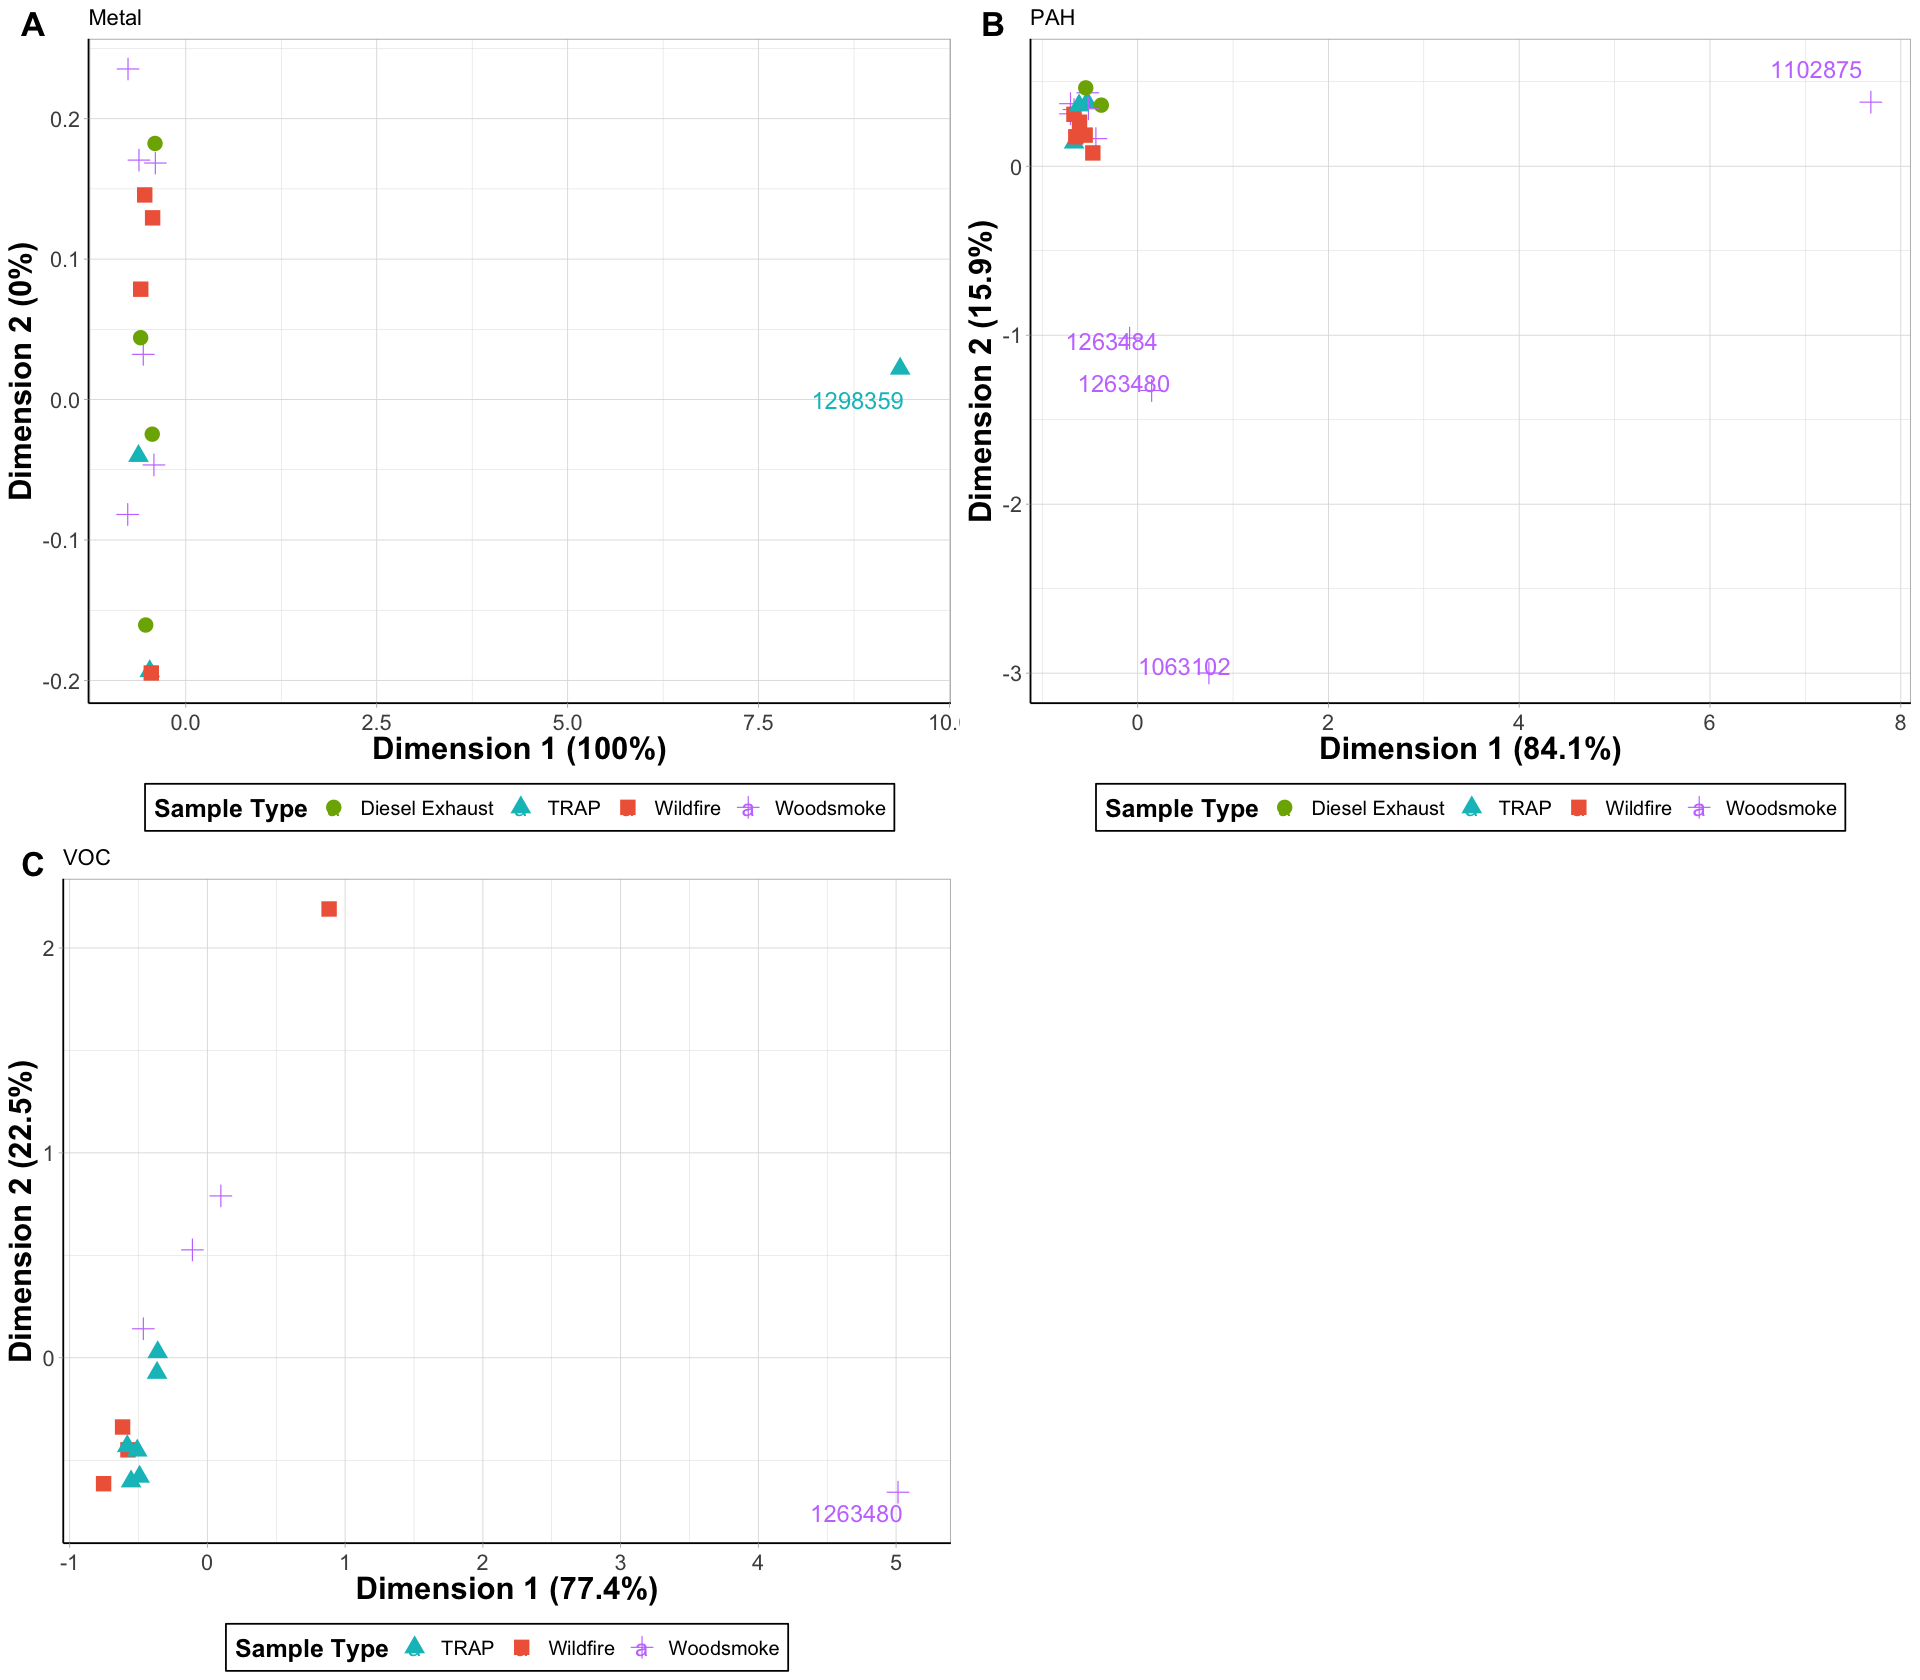

In [14]:
options(repr.plot.width=16, repr.plot.height=14) #changing size
vol_fig = plot_grid(vol1, vol2, vol3, nrow = 2,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.01, label_y = 1)
vol_fig

## Weight PCA Plot

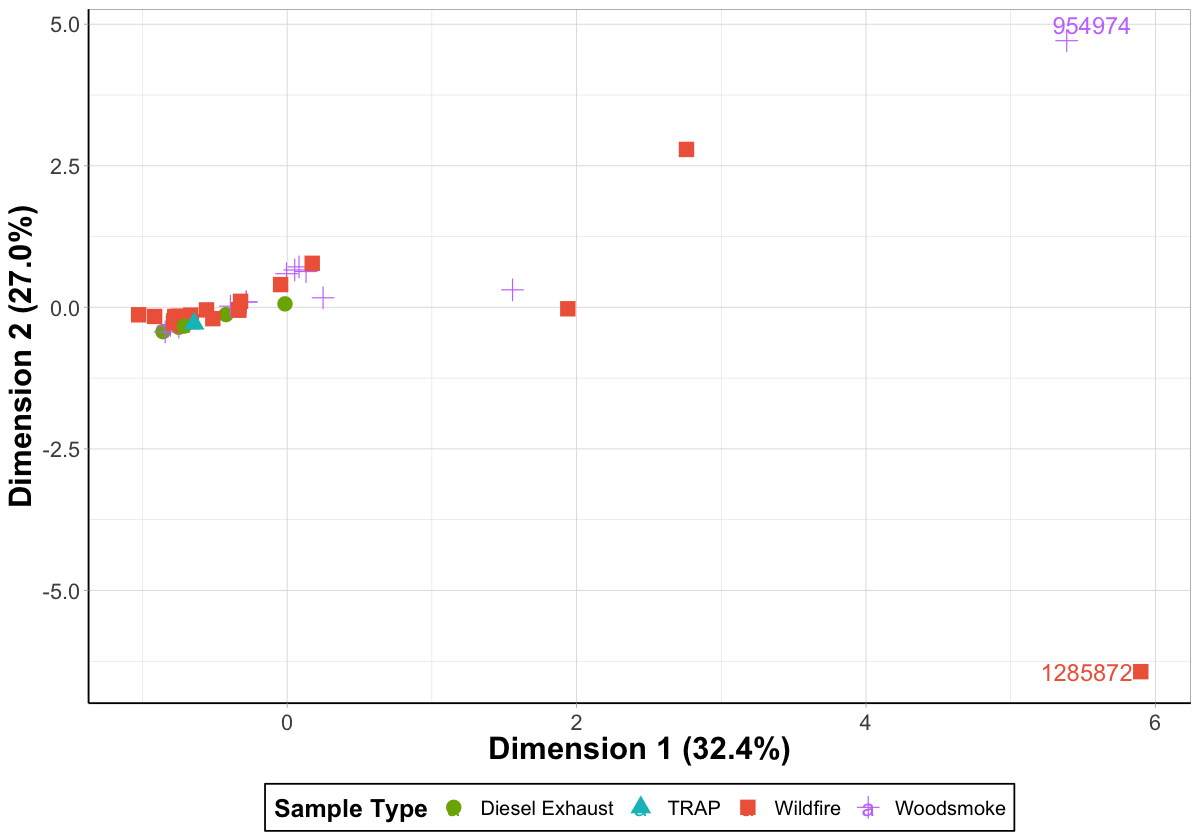

In [15]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'Metal'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'Metal', PC1 > 5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (32.4%)', y = 'Dimension 2 (27.0%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4])) 